In [1]:
import sys
path2cpp_pkg = "/Users/mariusmahiout/Documents/repos/ising_core/build"
sys.path.append(path2cpp_pkg)
import ising

import os
os.chdir("/Users/mariusmahiout/Documents/repos/ising_core/python")
import src.misc_plotting as plotting
import src.utils as utils
import src.model_eval as eval
import src.isingfitter as fitter

import matplotlib.pyplot as plt
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

In [2]:
num_units = 60
num_sims = 30_000
num_burn = 1000

In [3]:
##############
# SIMULATION #
##############

# setting up model
beta = 1.3
h = np.random.uniform(-.3 * beta, .3 * beta, num_units)
J = np.random.normal(0,  beta / np.sqrt(num_units), (num_units, num_units))
for i in range(num_units):
    J[i, i] = 0
    for j in range(i+1, num_units):
        J[j, i] = J[i, j]

true_model = ising.EqModel(J, h)

# simulating
true_sim = true_model.simulate(num_sims, num_burn)

In [5]:
def get_chi_analytic(h, J, i, j):
    num = np.exp(h[i] + h[j] + J[i,j]) - np.exp(h[i] - h[j] - J[i,j]) - np.exp(-h[i] + h[j] - J[i,j]) + np.exp(-h[i] - h[j] + J[i,j])
    den = np.exp(h[i] + h[j] + J[i,j]) + np.exp(h[i] - h[j] - J[i,j]) + np.exp(-h[i] + h[j] - J[i,j]) + np.exp(-h[i] - h[j] + J[i,j])
    return num / den

chi_analytic = np.zeros((num_units, num_units))
for i in range(num_units):
    for j in range(i, num_units):
        chi_analytic[i,j] = get_chi_analytic(h, J, i, j)
        chi_analytic[j,i] = chi_analytic[i,j]


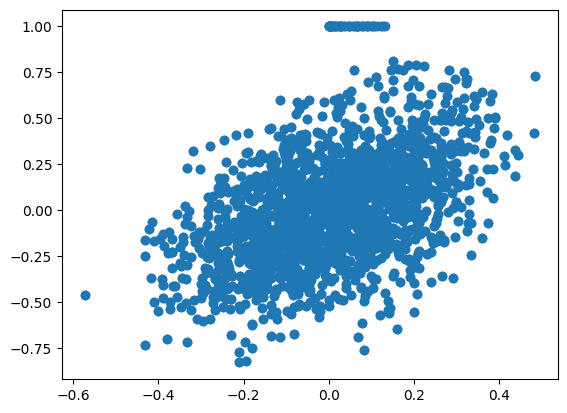

In [7]:
plt.scatter(chi_analytic, true_sim.getPairwiseCorrs())

### TO-DO: 
- confirm equation for chi_analytic, and derive equation for m_analytic
- make scatter plots
- plot sensitivity curves